DEBUG: Type of mean_H_over_time: <class 'numpy.ndarray'>
✅ DEBUG: Mean Hurst Exponent First 5 values: [1.49355331 1.55050009 1.53487376 1.46776712 1.58032494]
📁 Plot saved at: hurst_exponent_plot.png


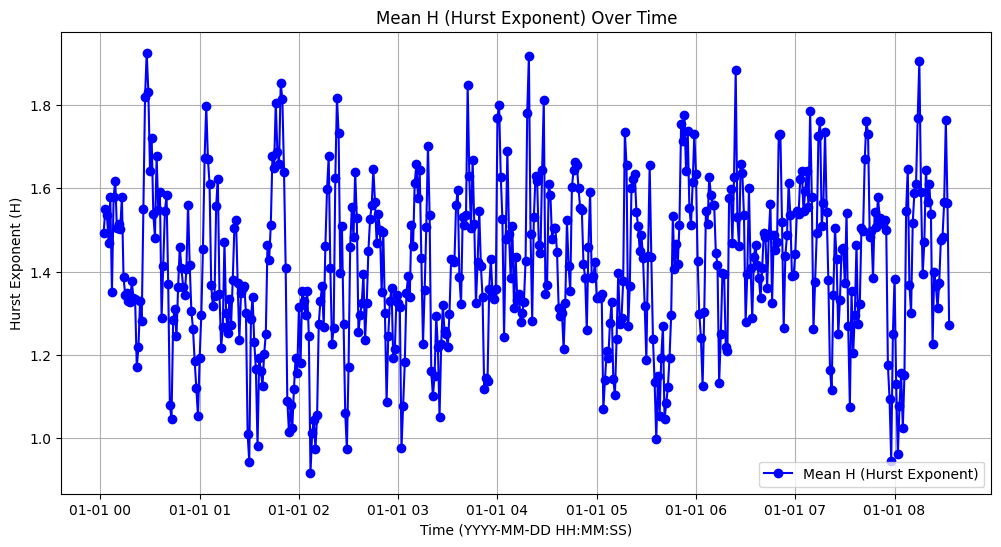

Spectrogram saved at: spectrogram_images\wavelet_spectrum.png


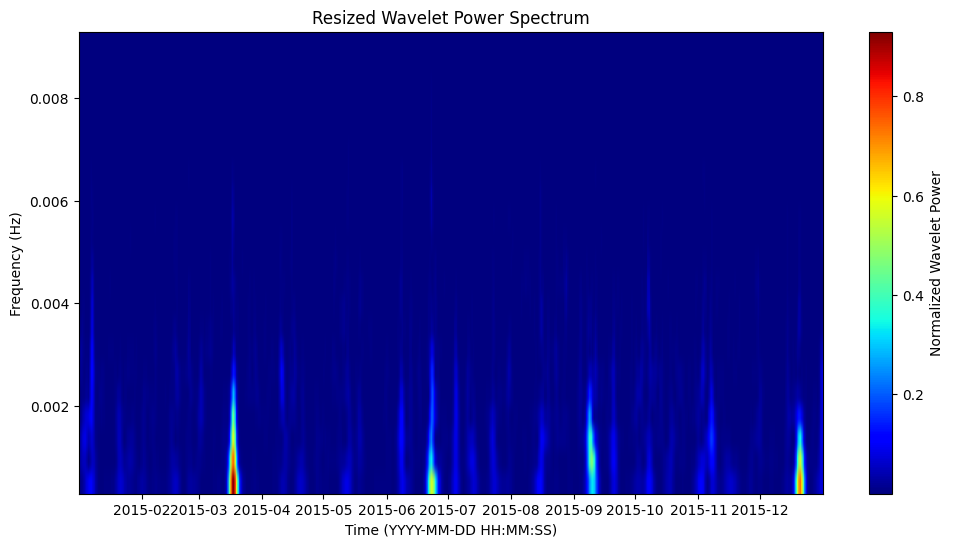

In [1]:
import numpy as np
import pywt
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from skimage.transform import resize
import os


def load_geomagnetic_data(file_path):
    """Loads geomagnetic data from a file."""
    data = pd.read_csv(file_path, sep=r'\s+', header=None, skiprows=17)
    data.columns = ["Date", "Time", "DOY", "ASY-D", "ASY-H", "SYM-D", "SYM-H"]
    data["Timestamp"] = pd.to_datetime(data["Date"] + " " + data["Time"])
    return data["Timestamp"].values, data["SYM-H"].values


def compute_wavelet_transform(geomagnetic_index, num_octaves=12, num_voices_per_octave=4):
    """Computes the continuous wavelet transform of the geomagnetic index."""
    wavelet = 'cmor1.5-1.0'
    min_scale = 1
    scales = min_scale * 2 ** (np.arange(num_octaves * num_voices_per_octave) / num_voices_per_octave)
    coefficients, frequencies = pywt.cwt(geomagnetic_index, scales, wavelet, 1)
    return coefficients, frequencies


def normalize_spectrum(power_spectrum):
    """Normalizes the power spectrum between 0 and 1."""
    return (power_spectrum - np.min(power_spectrum)) / (np.max(power_spectrum) - np.min(power_spectrum))


def downsample_time_axis(power_spectrum, target_width):
    """Reduces the number of time points using averaging to match target width."""
    return resize(power_spectrum, (power_spectrum.shape[0], target_width), mode='reflect', anti_aliasing=True)


def reduce_frequencies(power_spectrum, frequencies, target_height=256):
    """Reduces the number of frequency bands while preserving key information."""
    power_threshold = np.mean(power_spectrum) * 0.01  # Threshold for nearly-zero power
    selected_indices = np.where(np.mean(power_spectrum, axis=1) > power_threshold)[0]
    reduced_power_spectrum = power_spectrum[selected_indices, :]
    reduced_frequencies = frequencies[selected_indices]
    
    if len(reduced_frequencies) > target_height:
        reduced_power_spectrum = resize(reduced_power_spectrum, (target_height, reduced_power_spectrum.shape[1]), mode='reflect', anti_aliasing=True)
        reduced_frequencies = np.linspace(reduced_frequencies[0], reduced_frequencies[-1], target_height)
    
    return reduced_power_spectrum, reduced_frequencies

def compute_hurst_exponents(power_spectrum, frequencies, window_size=8, step_size=4):
    """Computes mean, max, and min Hurst exponents over time, along with R-values."""
    num_time_steps = power_spectrum.shape[1]
    
    mean_H_over_time = []
    max_H_over_time = []
    min_H_over_time = []
    r_values_over_time = []  # Store correlation coefficients
    
    for t in range(num_time_steps):
        log_frequencies = np.log(frequencies)
        log_power = np.log(power_spectrum[:, t] + 1e-10)  # Avoid log(0) issues
        
        slopes = []
        r_values = []  # Store r-values for this time step
        
        for start in range(0, len(log_frequencies) - window_size, step_size):
            end = start + window_size
            slope, _, r_value, _, _ = scipy.stats.linregress(log_frequencies[start:end], log_power[start:end])
            slopes.append(slope)
            r_values.append(r_value)  # Store r-value

        if slopes:
            hurst_exponents = abs((np.array(slopes) - 1) / 2)  # Compute Hurst exponent from slopes
            
            mean_H_over_time.append(np.nanmean(hurst_exponents))  # Compute mean Hurst exponent
            max_H_over_time.append(np.nanmax(hurst_exponents))  # Max Hurst exponent
            min_H_over_time.append(np.nanmin(hurst_exponents))  # Min Hurst exponent
            r_values_over_time.append(np.nanmean(r_values))  # Store mean r-value for this time step
        else:
            
            
            
             print(f"DEBUG: Type of mean_H_over_time: {type(mean_H_over_time)}")
             print(f"DEBUG: Type of max_H_over_time: {type(max_H_over_time)}")
             print(f"DEBUG: Type of min_H_over_time: {type(min_H_over_time)}")
             print(f"DEBUG: Type of r_values_over_time: {type(r_values_over_time)}")
       

 
    

    return np.array(mean_H_over_time), np.array(max_H_over_time), np.array(min_H_over_time), np.array(r_values_over_time)



def plot_wavelet_spectrum(timestamps, power_spectrum, frequencies, save_path=None):
    """Plots the wavelet spectrum with time labels and optionally saves the image."""
    plt.figure(figsize=(12, 6))
    plt.imshow(power_spectrum, aspect='auto', extent=[timestamps[0], timestamps[-1], frequencies[-1], frequencies[0]], cmap='jet')
    plt.colorbar(label="Normalized Wavelet Power")
    plt.xlabel("Time (YYYY-MM-DD HH:MM:SS)")
    plt.ylabel("Frequency (Hz)")
    plt.title("Resized Wavelet Power Spectrum")
    
    if save_path:
        # ✅ Ensure the directory exists before saving
        save_dir = os.path.dirname(save_path)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Spectrogram saved at: {save_path}")

    plt.show()




def save_spectrogram_image(power_spectrum, save_dir, filename="spectrogram.png"):
    """Saves the wavelet spectrogram as an image file for CNN input."""
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_path = os.path.join(save_dir, filename)
    plt.imsave(save_path, power_spectrum, cmap='jet')
    print(f"Spectrogram image saved at: {save_path}")

def plot_hurst_exponent(timestamps, hurst_exponents, exponent_type="mean", save_path="hurst_exponent_plot.png"):
    """Plots the selected Hurst exponent (mean, max, or min) vs. time."""
    
    if len(hurst_exponents) == 0:  # Just check the overall list
        print("❌ ERROR: No Hurst exponent values found. Check computation!")
        return
    
    plt.figure(figsize=(12, 6))

    # ✅ Correctly extract the correct array without misindexing
    if exponent_type == "mean":
        hurst_values = hurst_exponents
        label = r'Mean H (Hurst Exponent)'
        color = 'b'
    else:
        print("❌ ERROR: Invalid `exponent_type` value! For now, only 'mean' is supported.")
        return

    print(f"✅ DEBUG: {exponent_type.capitalize()} Hurst Exponent First 5 values: {hurst_values[:5]}")

    # ✅ Ensure timestamps match hurst exponent length
    timestamps = timestamps[:len(hurst_values)]

    # ✅ Plot the selected Hurst exponent
    plt.plot(timestamps, hurst_values, marker='o', linestyle='-', color=color, label=label)
    plt.xlabel("Time (YYYY-MM-DD HH:MM:SS)")
    plt.ylabel("Hurst Exponent (H)")
    plt.title(f"{label} Over Time")
    plt.legend()
    plt.grid()

    # ✅ Save the plot
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"📁 Plot saved at: {save_path}")

    plt.show()



# ✅ **Pipeline Execution**
file_path = "KyotoSymhYear2015.dat"

# 1️⃣ Load data
timestamps, geomagnetic_index = load_geomagnetic_data(file_path)

# 2️⃣ Compute wavelet transform
coefficients, frequencies = compute_wavelet_transform(geomagnetic_index)
power_spectrum = np.abs(coefficients) ** 2

# 3️⃣ Normalize and resize
normalized_spectrum = normalize_spectrum(power_spectrum)
resized_spectrum = downsample_time_axis(normalized_spectrum, target_width=512)
final_spectrum, final_frequencies = reduce_frequencies(resized_spectrum, frequencies)

# 4️⃣ Compute slopes
# Compute Hurst exponents (Mean, Max, Min)
mean_hurst, max_hurst, min_hurst, r_values  = compute_hurst_exponents(final_spectrum, final_frequencies)
print(f"DEBUG: Type of mean_H_over_time: {type(mean_hurst)}")
# Plot Mean Hurst exponent over time
plot_hurst_exponent(timestamps, mean_hurst)

# ✅ If needed, you can also plot max and min Hurst separately
# plot_slope_vs_time(timestamps, max_hurst)
# plot_slope_vs_time(timestamps, min_hurst)

# Plot and save spectrogram image
output_dir = "spectrogram_images"
plot_wavelet_spectrum(timestamps, final_spectrum, final_frequencies, save_path=os.path.join(output_dir, "wavelet_spectrum.png"))
